### Pangeo: Time Series of Global Near Surface Temperature and Precipitation Anomalies from One Model

**Packages:**

- matplotlib
- numpy
- cftime
- pandas 
- xarray 
- intake 
- intake-esm 

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np

#package for sharing and loading datasets
import intake

In [2]:
#url for connecting Pangeo
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"

#opening datacatalog using intake_esm
dataframe = intake.open_esm_datastore(url)

In [3]:
#searching surface temperature datasets
tas_models = dataframe.search(experiment_id=['historical', 'ssp585'], source_id=['CESM2-WACCM'],  member_id ='r1i1p1f1', table_id='Amon', variable_id='tas')
tas_models.df


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
1,ScenarioMIP,NCAR,CESM2-WACCM,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/...,NaN,20200702


In [4]:
#loading datasets into dictionary where they can be accessed
tas_datasets = tas_models.to_dataset_dict()
#next we want to see the keys to each dataset
for key in tas_datasets.keys():
    print(key)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn
CMIP.NCAR.CESM2-WACCM.historical.Amon.gn


In [5]:
#(marking historical data as 1 and ssp as 2)
ds_tas1 = tas_datasets['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
ds_tas2 = tas_datasets['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn']
ds_tas1

<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, member_id: 1, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   20075.0
    case_id:                 4
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/55a8af4c-3729-4051-9e53-f22295c2ec1c
    version_id:              v20190227
    intake_esm_varname:      ['tas']
    intake_esm_dataset_key:  CMIP.NCAR.CESM2-WACCM.historical.Amon.gn

In [6]:
#searching for precipitation datasets
pr_models = dataframe.search(experiment_id=['historical', 'ssp585'], source_id=['CESM2-WACCM'],  member_id ='r1i1p1f1', table_id='Amon', variable_id='pr')
pr_models.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190415
1,ScenarioMIP,NCAR,CESM2-WACCM,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/...,NaN,20200702


In [7]:
#loading datasets into easy to access dictionary
pr_datasets = pr_models.to_dataset_dict()
#next we want to see the keys to each dataset
for k in pr_datasets.keys():
    print(k)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn
CMIP.NCAR.CESM2-WACCM.historical.Amon.gn


In [8]:
#and the same as earlier for precipitation
ds_pr1 = pr_datasets['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
ds_pr2 = pr_datasets['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn']

In [9]:
#calculate global mean

def GlobalMean(data):
    #creating weights to weight data according to surface area
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    #calculating weighted global means
    data_weighted = data.weighted(weights)
    weighted_mean = data_weighted.mean(("lon", "lat"))
    return weighted_mean

In [10]:
#calculating annual mean values from the temperature data
tas1 = ds_tas1.tas.isel(member_id=0).groupby('time.year').mean('time')
tas2 = ds_tas2.tas.isel(member_id=0).groupby('time.year').mean('time')

#mean of reference period
tas_rel = tas1.sel(year = slice('1850','1900')).mean('year')

In [11]:
#annual means of precipitation
pr1 = ds_pr1.pr.isel(member_id=0).groupby('time.year').mean('time')
pr2 = ds_pr2.pr.isel(member_id=0).groupby('time.year').mean('time')

#mean of reference period
pr_rel = pr1.sel(year = slice('1850','1900')).mean('year')

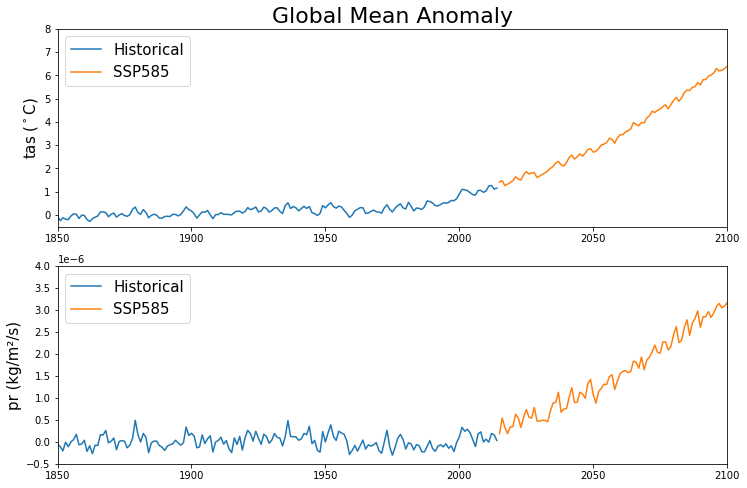

In [12]:
#creating a figure with two subplots
fig,[ax1,ax2] = plt.subplots(2, figsize=(12,8))

#Plot 1
ax1.plot(tas1.year,GlobalMean(tas1-tas_rel), label='Historical')
ax1.plot(tas2.year,GlobalMean(tas2-tas_rel), label='SSP585')
ax1.set_ylabel('tas ($ ^\circ $C)', size=15)
ax1.set_title('Global Mean Anomaly', size=22)
ax1.set_ylim(-0.5,8)
ax1.set_xlim(1850,2100)
ax1.legend(fontsize=15)

#Plot 2
ax2.plot(pr1.year, GlobalMean(pr1-pr_rel), label='Historical')
ax2.plot(pr2.year,GlobalMean(pr2-pr_rel), label='SSP585')
ax2.set_ylabel('pr (kg/m²/s)', size=15)
ax2.set_ylim(-0.05e-5,0.4e-5)
ax2.set_xlim(1850,2100)
ax2.legend(fontsize=15)
plt.show()